## Deep Reinforcement Learning (DQN)

#### Autores:
- Celia Quiles Aleman - 202315604@alu.comillas.edu
 - Álvaro Ezquerro Pérez - alvaroezquerro@alu.comillas.edu
 - María Calvo de Mora Román - 202320059@alu.comillas.edu

#### Desarrollado por:
María Calvo de Mora Román

#### Importación de librerías

In [1]:
import numpy as np
import gym
import pickle
import tensorflow as tf
from tensorflow import keras
from collections import deque
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from skimage.color import rgb2gray
from skimage.transform import resize
from tqdm import tqdm

from src.utils.plotting import plot_blackjack_performance

#### Creación del entorno

In [2]:
# Establecer semillas para reproducibilidad
np.random.seed(42)
tf.random.set_seed(42)

# Crear el entorno
env = gym.make("Blackjack-v1", natural=False)
input_shape = [3]
n_outputs = env.action_space.n

#### Modelo de red neural, política y conjunto de experiencias

In [3]:
# Modelo de red neuronal
model = keras.models.Sequential([
    keras.layers.Dense(128, activation="elu", input_shape=input_shape),
    keras.layers.Dense(64, activation="elu", input_shape=input_shape),
    keras.layers.Dense(32, activation="elu"),
    keras.layers.Dense(n_outputs)
])

c:\Users\mcalv\anaconda3\envs\ML2-DL\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [4]:
# Política epsilon-greedy
def epsilon_greedy_policy(state, epsilon=0):
    """ Función que implementa la política epsilon-greedy 
    Args:
        state: estado actual
        epsilon: probabilidad de exploración
    Returns:
        acción a tomar"""
    if np.random.rand() < epsilon:
        return env.action_space.sample()
    else:
        state_array = np.array(state)  # Convertir estado a un array de NumPy con la forma adecuada
        Q_values = model.predict(state_array, verbose=0)[0]
        return np.argmax(Q_values)

In [5]:
# Memoria de repetición
replay_memory = deque(maxlen=2000)

In [6]:
# Muestreo de experiencias
def sample_experiences(batch_size):
    """ Función que muestrea experiencias de la memoria de repetición
    Args:
        batch_size: tamaño de la muestra
    Returns:
        estados, acciones, recompensas, siguientes estados, banderas de terminación"""
    indices = np.random.randint(len(replay_memory), size=batch_size)
    batch = [replay_memory[index] for index in indices]
    states, actions, rewards, next_states, dones = [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(5)]
    return states, actions, rewards, next_states, dones

In [7]:
# Jugar un paso
def play_one_step(env, state, epsilon):
    """ Función que juega un paso en el entorno
    Args:
        env: entorno
        state: estado actual
        epsilon: probabilidad de exploración
    Returns:
        siguiente estado, recompensa, bandera de terminación, información"""
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, tr,info = env.step(action)
    next_state = np.array(next_state)  
    replay_memory.append((state, action, reward, next_state, done))
    return next_state, reward, done, info

#### Entrenamiento

In [8]:
batch_size = 32
discount_rate = 0.95
optimizer = keras.optimizers.Adam(learning_rate=1e-2)
loss_fn = keras.losses.MeanSquaredError(
    reduction="sum_over_batch_size", name="mean_squared_error"
)

# Funcion que muestrea experiencias y entrena el modelo
def training_step(batch_size):
    """ Función que muestrea experiencias y entrena el modelo
    Args:
        batch_size: tamaño de la muestra
    """
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    next_Q_values = model.predict(next_states)
    max_next_Q_values = np.max(next_Q_values, axis=1)
    target_Q_values = (rewards + (1 - dones) * discount_rate * max_next_Q_values)
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [9]:
# Entrenar al agente
rewards = [] 
best_score = 0

for episode in range(600):
    print("Episode:   ", episode)
    obs = env.reset()
    obs=obs[0]
    obs = np.array(obs)
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        if done:
            #print("done:   ", done)
            break
    rewards.append(step) # Not shown 
    if step >= best_score: # Not shown
        best_weights = model.get_weights() # Not shown
        best_score = step # Not shown
    print("\rEpisode: {}, Steps: {}, eps: {:.3f}".format(episode, step + 1, epsilon), end="") # Not shown
    if episode > 50:
        training_step(batch_size)

model.set_weights(best_weights)
env.close()

# Guardar el modelo entrenado en un archivo
with open('src/models/dqn_model.pkl', 'wb') as f:
    pickle.dump(model, f)

Episode:    0
Episode: 0, Steps: 2, eps: 1.000Episode:    1
Episode: 1, Steps: 1, eps: 0.998Episode:    2
Episode: 2, Steps: 1, eps: 0.996Episode:    3
Episode: 3, Steps: 1, eps: 0.994Episode:    4
Episode: 4, Steps: 2, eps: 0.992Episode:    5
Episode: 5, Steps: 4, eps: 0.990Episode:    6
Episode: 6, Steps: 1, eps: 0.988Episode:    7
Episode: 7, Steps: 2, eps: 0.986Episode:    8
Episode: 8, Steps: 2, eps: 0.984Episode:    9
Episode: 9, Steps: 1, eps: 0.982Episode:    10
Episode: 10, Steps: 1, eps: 0.980Episode:    11
Episode: 11, Steps: 1, eps: 0.978Episode:    12
Episode: 12, Steps: 2, eps: 0.976Episode:    13
Episode: 13, Steps: 1, eps: 0.974Episode:    14
Episode: 14, Steps: 1, eps: 0.972Episode:    15
Episode: 15, Steps: 1, eps: 0.970Episode:    16
Episode: 16, Steps: 2, eps: 0.968Episode:    17
Episode: 17, Steps: 1, eps: 0.966Episode:    18
Episode: 18, Steps: 2, eps: 0.964Episode:    19
Episode: 19, Steps: 1, eps: 0.962Episode:    20
Episode: 20, Steps: 1, eps: 0.960Episode:    

c:\Users\mcalv\anaconda3\envs\ML2-DL\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode: 22, Steps: 2, eps: 0.956Episode:    23
Episode: 23, Steps: 3, eps: 0.954Episode:    24
Episode: 24, Steps: 1, eps: 0.952Episode:    25
Episode: 25, Steps: 1, eps: 0.950Episode:    26
Episode: 26, Steps: 1, eps: 0.948Episode:    27
Episode: 27, Steps: 1, eps: 0.946Episode:    28
Episode: 28, Steps: 1, eps: 0.944Episode:    29
Episode: 29, Steps: 1, eps: 0.942Episode:    30
Episode: 30, Steps: 2, eps: 0.940Episode:    31
Episode: 31, Steps: 1, eps: 0.938Episode:    32
Episode: 32, Steps: 1, eps: 0.936Episode:    33
Episode: 33, Steps: 1, eps: 0.934Episode:    34
Episode: 34, Steps: 1, eps: 0.932Episode:    35
Episode: 35, Steps: 1, eps: 0.930Episode:    36
Episode: 36, Steps: 1, eps: 0.928Episode:    37
Episode: 37, Steps: 1, eps: 0.926Episode:    38
Episode: 38, Steps: 1, eps: 0.924Episode:    39
Episode: 39, Steps: 1, eps: 0.922Episode:    40
Episode: 40, Steps: 1, eps: 0.920Episode:    41
Episode: 41, Steps: 1, eps: 0.918Episode:    42
Episode: 42, Steps: 1, eps: 0.916Episode

#### Evaluación

In [13]:
render = False  # Si quieremos mostrar la evaluación o no (si es True, se recomienda un bajo episodio de evaluación)

# Entorno
if render:
    env = gym.make('Blackjack-v1', render_mode="human")
else:
    env = gym.make('Blackjack-v1')

# Cargar el modelo entrenado desde el archivo pickle
with open('src/models/dqn_model.pkl', 'rb') as f:
    model = pickle.load(f)

In [11]:
def evaluate_dqn_model(env, model, n_episodes):
    """Evalúa el modelo DQN en un número dado de episodios usando la misma lógica de toma de decisiones que durante el entrenamiento.
    Args:
        env: El entorno de Gym.
        model: El modelo DQN.
        n_episodes: El número de episodios para evaluar.
    Returns:
        Un conjunto de métricas de evaluación.
    """
    total_rewards = 0
    total_penalties = 0
    total_steps = 0
    wins = 0

    for episode in range(n_episodes):
        state, _ = env.reset()
        state = np.array(state[0])
        episode_rewards = 0
        done = False

        while not done:
            epsilon = 0  # Sin exploración durante la evaluación
            state, reward, done, info = play_one_step(env, state, epsilon)
            episode_rewards += reward
            total_steps += 1

            if reward == -1:
                total_penalties += 1
            elif reward > 0:
                wins += 1

        total_rewards += episode_rewards

    win_rate = wins / n_episodes

    
    return win_rate, total_rewards, total_penalties, total_steps

100%|██████████| 1000/1000 [01:17<00:00, 12.86it/s]

Recompensa media: -0.066, Duración media episodios: 1.557


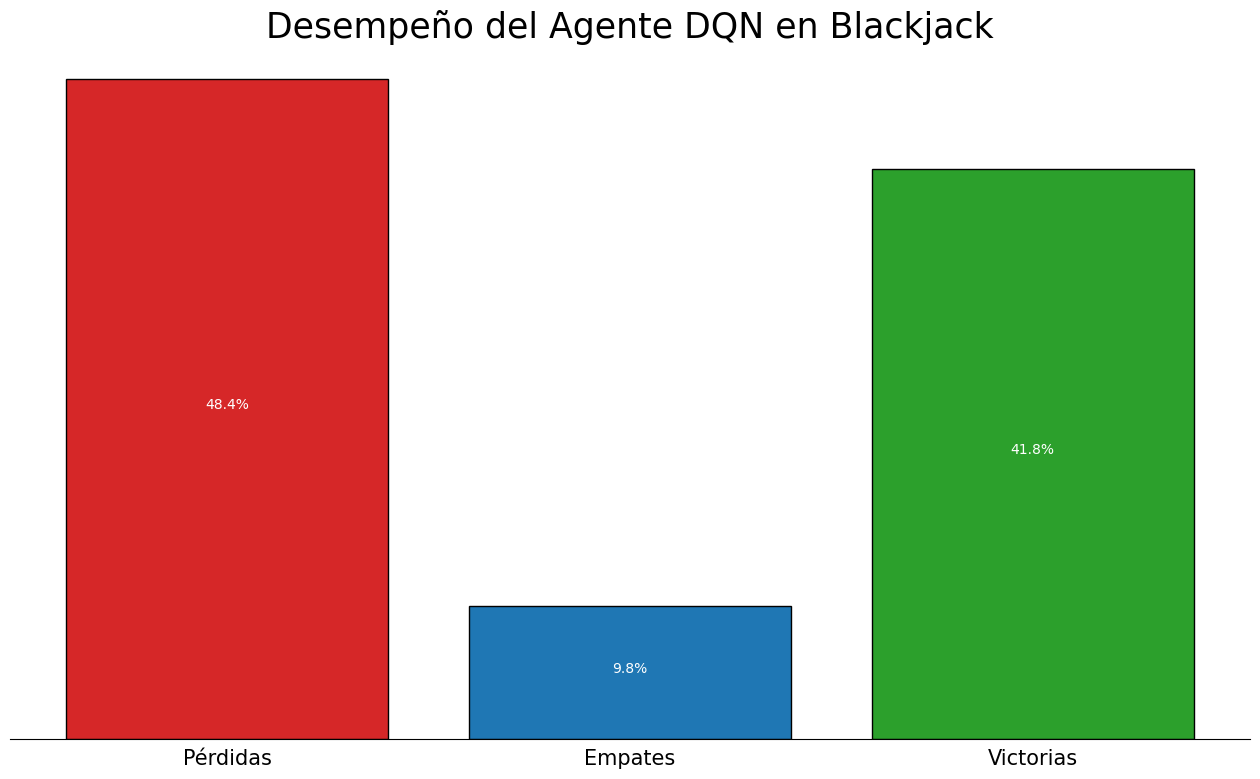

In [16]:
def evaluate_dqn_agent(env, network, num_episodes=1000):
    total_rewards = []
    total_steps = 0

    for _ in tqdm(range(num_episodes)):
        state, _ = env.reset()
        episode_reward = 0
        episode_steps = 0
        done = False

        while not done:
            epsilon = 0  # Sin exploración durante la evaluación
            state, reward, done, info = play_one_step(env, state, epsilon)
            episode_reward += reward
            episode_steps += 1

        total_rewards.append(episode_reward) 
        total_steps += episode_steps

    avg_reward = sum(total_rewards) / num_episodes
    avg_episode_length = total_steps / num_episodes

    return avg_reward, avg_episode_length, total_rewards

# Example usage:
avg_reward, avg_episode_length, total_rewards= evaluate_dqn_agent(env, model, num_episodes=1000)
print(f"Recompensa media: {avg_reward}, Duración media episodios: {avg_episode_length}")
plot_blackjack_performance(total_rewards, "Desempeño del Agente DQN en Blackjack")

In [60]:
def plot_results(win_rate, total_rewards, total_penalties, total_steps, title):
    """ Función que muestra los resultados obtenidos en forma de gráfico de barras.
    Args:
        win_rate: Tasa de victorias del agente.
        total_rewards: Recompensa total alcanzada en el entrenamiento.
        total_penalties: Penalización total alcanzada en el entrenamiento.
        total_steps: Número total de pasos alcanzados durante el entrenamiento.
        title: Título del gráfico.
    """
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 5)
    categories = ['Tasa de Victorias', 'Recompensas Totales', 'Penalizaciones Totales', 'Pasos Totales']
    values = [win_rate, total_rewards, total_penalties, total_steps]
    colors = ['gold', 'blue', 'red', 'green']
    bars = ax.bar(categories, values, color=colors)
    
    ax.set_ylabel('Valores')
    ax.set_title(title)
    
    for bar in bars:
        yval = bar.get_height()
        position = yval - 0.05 if yval < 0 else yval + 0.05
        ax.text(bar.get_x() + bar.get_width()/2.0, position, round(yval, 2), va='center', ha='center')
    
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_results_for_episode(results_df, title):
    """ Función que muestra los resultados obtenidos en forma de gráfico de barras.
    Args:
        results_df: DF de resultados de cada episodio.
        title: Título del gráfico.
    """
    fig, axs = plt.subplots(2, 2, figsize=(10, 8))

    colors = ['gold', 'blue', 'red', 'green']

    for i, col in enumerate(results_df.columns):
        ax = axs[i // 2, i % 2]
        ax.plot(results_df.index, results_df[col], color=colors[i])
        ax.set_title(col)
    
    plt.tight_layout()
    plt.show()

0.399 -130.0 529 1176


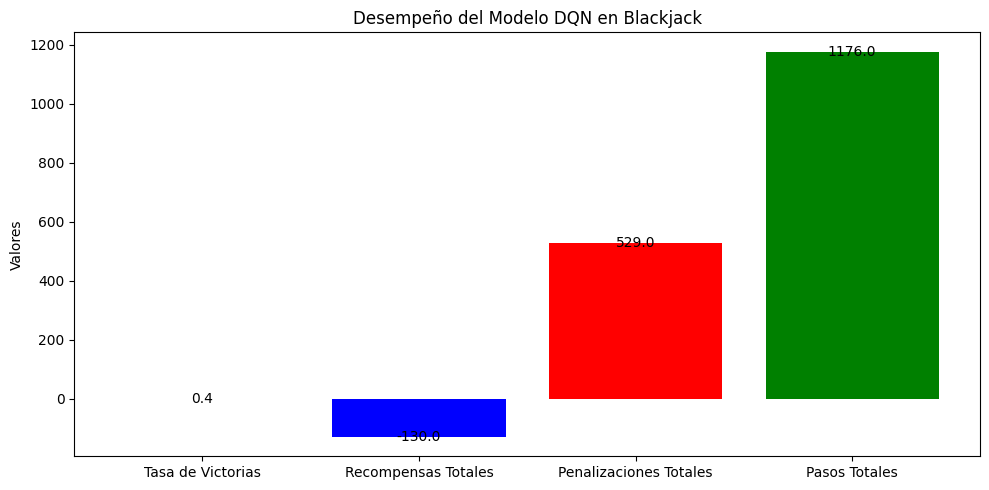

In [61]:
win_rate, total_rewards, total_penalties, total_steps = evaluate_dqn_model(env, model, n_episodes=1000)
print(win_rate, total_rewards, total_penalties, total_steps)
title = 'Desempeño del Modelo DQN en Blackjack'
plot_results(win_rate, total_rewards, total_penalties, total_steps, title)
env.close()